In [1]:
import numpy as np
import pandas as pd
import sympy
from sympy import *
from operator import mul
from functools import reduce
import mpmath as mp
from mpmath import fac
import functools
from sympy import init_printing
from sympy.core.decorators import _sympifyit, call_highest_priority
from IPython.display import display_latex
init_printing()

# Lie Map
$$e^{:f:} = \sum_n \frac{:f:^n}{n!},
\\
:f: = \left[f, \cdot \right]
= \frac{\partial f}{\partial x} \frac{\partial \cdot }{\partial p} - \frac{\partial f}{\partial p} \frac{\partial \cdot}{\partial x} $$

In [2]:
class LieOperator:
    '''
    Lie Operator Class
    '''
    def __init__(self, ham, indep_coords, indep_mom):
        self._ham = ham 
        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]

        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
        self._indep_coords = indep_coords
        self._indep_mom = indep_mom
    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
    
    #Calcualte Poisson bracket with input function
    def Poisson(self,other):
        h = S(0)
        for qi,pi in zip(self.indep_coords,self.indep_mom):
            h += self.ham.diff(qi) * other.ham.diff(pi) 
            h -= self.ham.diff(pi) * other.ham.diff(qi)

        return h

In [3]:
class LieMap(LieOperator):
    '''
    Lie transform map
    Inherits Lie Operator structure
    '''
    
    #Successively apply Poisson bracket to input function to the input cutoff
    def ExpPowerLieBracket(self, other, power):
        s = 0
        if power == 0:
            s += other
        else:
            s += self.Poisson(self.ExpPowerLieBracket(other, power - 1))
            
        return s
    
    
    #Calculate the exponential map of the Lie operator to the input cutoff
    def exp(self,other,power):
        s = 0
        for i in range(power+1):
            s += sympy.Rational(1,factorial(i))*self.ExpPowerLieBracket(other,i)
        return s

In [4]:
type(sympy.Rational(1,factorial(6)))

sympy.core.numbers.Rational

In [5]:
# x,px,y,py = sympy.symbols('x px y py')
# coords = [x,y]
# mom = [px,py]
x, p = sympy.symbols('x p')
H = sympy.Function('H1', commutative=False)(x,p)
g = sympy.Function('H2', commutative=False)(x,p)
la = LieOperator(H,x,p)
lb = LieOperator(g,x,p)
mb = LieMap(H,x,p)
mc = LieMap(g,x,p)

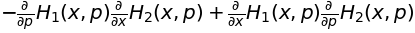

In [6]:
la.Poisson(lb)

In [7]:
y = x.subs(x,1)
z = sympy.Rational(1,factorial(6))

In [8]:
y.is_number

True

In [9]:
z.is_number

True

In [10]:
type(z*H)

sympy.core.mul.Mul

In [11]:
type(1)

int

In [12]:
lb*H

TypeError: unsupported operand type(s) for *: 'LieOperator' and 'H1'

In [ ]:
la.ham, la.indep_coords, la.indep_mom

In [ ]:
t = lb.Poisson(g)
t

In [ ]:
t.subs(H, x)

In [ ]:
lb.ExpPowerLieBracket(g,2)

In [ ]:
lb.exp(g,3)

In [ ]:
n = 4
def pn(n):
    F = sympy.Matrix(np.zeros((n+1,n+1)))
    for i in range(n+1):
        for j in range(n+1):
            if (j-i)>=0:
                F[i,j] = sympy.Rational(1,int(fac(j-i))) # keep it rational !!!!


    
    G = sympy.Matrix(np.zeros((n+1,n+1)))
    for i in range(n+1):
        for j in range(n+1):
            if (j-i)>=0:
                if i==j:
                    sigprod = 1
                else:
                    l = sympy.symbols('s{}:{}'.format(i,j))
                    sigprod = reduce(sympy.Mul,l)
                G[i,j] = sympy.Mul(sympy.Rational(1,int(np.math.factorial(j-i))),sigprod, evaluate=False)



    qthpower = sympy.Matrix(np.eye(n+1))

    FGm1 = sympy.nsimplify(F*G - qthpower)

    FGm1


    summ = 0

    for q in range(1,n+1):
        qthpower = sympy.nsimplify(sympy.MatMul(qthpower, FGm1, evaluate=False))

        summ += sympy.nsimplify((-1)**(q-1)/q * qthpower)[0,n] # q-1 because mathematica starts at 1 and not 0, there for sign change

    return sympy.expand(summ)

def translated(op1,op2,n):
    l = sympy.symbols('s{}:{}'.format(0,n))
    temp = reduce(functools.partial(sympy.Mul,evaluate=False),[k*k for k in l])
    temp = sympy.expand(sympy.Mul(temp, pn(n), evaluate=False),evaluate=False)
    with sympy.evaluate(False):
        ln = sympy.symbols('r{}:{}'.format(0,n), commutative=False)
        for i, s in enumerate(l):
            temp = temp.subs(l[i],ln[i])
        for i in range(n):
            f = sympy.Symbol('f',commutative=False)
            g = sympy.Symbol('g',commutative=False)
            temp = temp.subs(ln[i]**3,g)
            temp = temp.subs(ln[i]**2,f)
            temp = temp.subs(g**0,1)
        
        print(type(op1))
        temp = temp.subs(f,op1)
        temp = temp.subs(g,op2)
    
    return temp

def HCB(op1,op2,n):
    s = 0
    for i in range(1,n+1):
        s+= translated(op1,op2,i)
    return sH1(𝑥,

In [ ]:
translated(H,g,1)

In [ ]:
la.ham

In [ ]:
HCB(H,g,2)

In [ ]:
HCB(la.ham,lb.ham,2)

In [ ]:
HCB(H,g,2)

In [ ]:
Z = sympy.Function('Z', commutative=False)(x,p)
W = sympy.Function('W', commutative=False)(x,p)
h = HCB(Z,W,3)
f = HCB(h,H,2)
test = LieMap(h,x,p)
test2 = LieMap(f,x,p)

In [ ]:
test.ham, test.indep_coords, test.indep_mom

In [ ]:
test2.ham, test2.indep_coords, test2.indep_mom

In [ ]:
test.Poisson(H)

# Drift Space test run

In [ ]:
x, y, px, py, delta = sympy.symbols('x y px py d')
Hd = - sympy.sqrt((1+delta)**2 - px**2 - py**2)

In [ ]:
Hd

In [ ]:
drift = LieMap(Hd,[x,y],[px,py])

In [ ]:
drift.ham, drift.indep_coords, drift.indep_mom

In [ ]:
drift.exp(x,8)

In [ ]:
drift.exp(px,8)

In [ ]:
drift.exp(y,8)

In [ ]:
drift.exp(py,8)

## Applying with quadrupole

In [ ]:
x,p,k = sympy.symbols('x p k')
Hq = -sympy.Rational(1,2)*(k*x**2 + p**2)

In [ ]:
Hq

In [ ]:
quadrupole = LieMap(Hq,x,p)

In [ ]:
quadrupole.ham, quadrupole.indep_coords, quadrupole.indep_mom

In [ ]:
quadrupole.Poisson(x)

In [ ]:
quadrupole.Poisson(quadrupole.Poisson(x))

In [ ]:
quadrupole.exp(x,0)

In [ ]:
quadrupole.exp(x,10)

In [ ]:
from sympy import cos, sin, series
sympy.series(cos(sympy.sqrt(k))*x,k)

In [ ]:
sympy.series(sin(sympy.sqrt(k))*p/sympy.sqrt(k),k)

In [ ]:
quadrupole.exp(p,10)

In [ ]:
sympy.series(-sympy.sqrt(k)*sin(sympy.sqrt(k))*x,k)

In [ ]:
sympy.series(cos(sympy.sqrt(k))*p,k)